## Telco Customer Churn

The goal of this project is to predict if a customer would churn or not. It would help the company retain customers. Dataset is obtained from kaggle https://www.kaggle.com/blastchar/telco-customer-churn

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data = pd.read_csv('telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv',
                   na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',' ','NA'],keep_default_na=False)

In [14]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [15]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(object)

In [16]:
cont = data.select_dtypes(exclude=['object'])

### Visualization

Following is the visualization of the distribution continuous features. There are peaks in all the three variables.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000294C505AB70>,
      dtype=object)

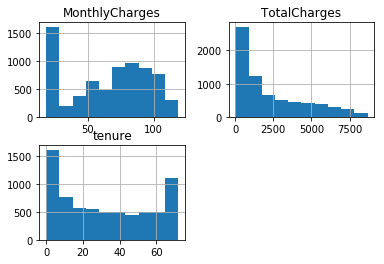

In [17]:
cont.hist()

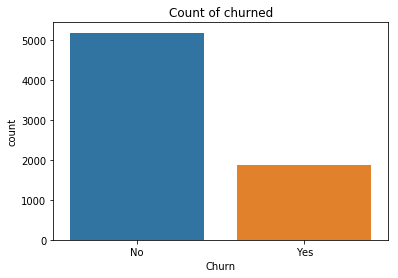

In [18]:
import seaborn as sns
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='Churn', data=data)
plt.title("Count of churned")
plt.show()

The above is the distribution of the target variable. It is seen that the dataset is imbalanced. 73% of the data consists of "Yes" category and 26% consists of "No" category.

In [8]:
n=len(data)
app_0=len(data[data['Churn']=='Yes'])
app_1=len(data[data['Churn']=='No'])

print("% churn train dataset: ",app_1*100/n)
print("% no churn in train dataset: ",app_0*100/n)

% churn train dataset:  73.46301292063042
% no churn in train dataset:  26.536987079369588


In [7]:
data_y = data[['Churn']]
data_x = data.drop(columns=['Churn','customerID'])

### Splitting data in train and test set

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y)

The following code runs 3 models - Logistic regression, SVC and Nearest Centroid using pipeline. 

In [29]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestCentroid
from sklearn.impute import SimpleImputer
import numpy as np


import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object

    preprocess = make_column_transformer((SimpleImputer(strategy='mean',missing_values=np.nan),
                                          ~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    pipe_lr = make_pipeline(preprocess,LogisticRegression())
    pipe_svc = make_pipeline(preprocess,LinearSVC())
    pipe_nc = make_pipeline(preprocess,NearestCentroid())
    scores_lr = cross_val_score(pipe_lr, X_train, y_train)
    scores_svc = cross_val_score(pipe_svc, X_train, y_train)
    scores_nc = cross_val_score(pipe_nc, X_train, y_train)

In [31]:
print("logistic regression mean accuracy : " + str(scores_lr.mean()))
print("SVC mean accuracy : " + str(scores_svc.mean()))
print("Nearest centroid mean accuracy : " + str(scores_nc.mean()))

logistic regression mean accuracy : 0.8048111007863988
SVC mean accuracy : 0.7826580326260905
Nearest centroid mean accuracy : 0.5223375148417737


From the above, it is seen that logistic regression performs in par with the linear SVC. Nearest centroid method is the least performing one among the three.

Let us try scaling the continuous variables and evaluate the models.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object


    pipe_cont = make_pipeline(SimpleImputer(strategy='mean',missing_values=np.nan),
                                         (StandardScaler()))
    
    preprocess = make_column_transformer((pipe_cont,~categorical),
                                         (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    
    pipe_lr = make_pipeline(preprocess,LogisticRegression())
    pipe_svc = make_pipeline(preprocess,StandardScaler(),LinearSVC())
    pipe_nc = make_pipeline(preprocess,StandardScaler(),NearestCentroid())
    scores_lr = cross_val_score(pipe_lr, X_train, y_train)
    scores_svc = cross_val_score(pipe_svc, X_train, y_train)
    scores_nc = cross_val_score(pipe_nc, X_train, y_train)

In [33]:
print("logistic regression mean score : " + str(scores_lr.mean()))
print("SVC mean score : " + str(scores_svc.mean()))
print("Nearest centroid mean score : " + str(scores_nc.mean()))

logistic regression mean score : 0.8046222445924319
SVC mean score : 0.8029183444323991
Nearest centroid mean score : 0.709014226593017


Scaling continuous variables has a huge impact in the performance of SVC and nearest centroid. The score improved from 0.52 to 0.70 in nearest centroid and for SVC it improved from 0.71 to 0.80. This is because, distance-based algorithms likes SVC and nearest centroid need features to be scaled so that distance is uniformly computed.

### Tuning hyper parameters

In [34]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    categorical = X_train.dtypes == object
    pipe_cont = make_pipeline(SimpleImputer(strategy='mean'),
                                         (StandardScaler()))
    
    preprocess = make_column_transformer((pipe_cont,~categorical),
                                         (OneHotEncoder(handle_unknown='ignore',sparse=False),categorical),
                                         remainder='passthrough')
    param_lsvc = {'linearsvc__C': np.logspace(-3, 2, 6)}
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    param_nc = {'nearestcentroid__shrink_threshold': [1,10,100,1000]}
    
    gs_lsvc = GridSearchCV(estimator=make_pipeline(preprocess,LinearSVC()),
                           param_grid=param_lsvc)
    gs_lsvc.fit(X_train,y_train)
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression()),
                         param_grid=param_lr)
    gs_lr.fit(X_train,y_train)
    gs_nc = GridSearchCV(estimator=make_pipeline(preprocess,NearestCentroid()),
                         param_grid=param_nc)
    gs_nc.fit(X_train,y_train)


In [35]:
print(gs_lsvc.best_params_)
print(gs_lsvc.best_score_)
print(gs_lr.best_params_)
print(gs_lr.best_score_)
print(gs_nc.best_params_)
print(gs_nc.best_score_)

{'linearsvc__C': 1.0}
0.8032942067398713
{'logisticregression__C': 1}
0.8046194623248769
{'nearestcentroid__shrink_threshold': 1}
0.7321090496024233


Hyper parameter tuning improved nearest centroid accuracy from 0.70 to 0.73. Otherwise, there is no big change in the performances.

Visualize performance as a function of parameters

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    results_lsvc = pd.DataFrame(gs_lsvc.cv_results_)
    results_lr = pd.DataFrame(gs_lr.cv_results_)
    results_nc = pd.DataFrame(gs_nc.cv_results_)

Text(0, 0.5, 'Score')

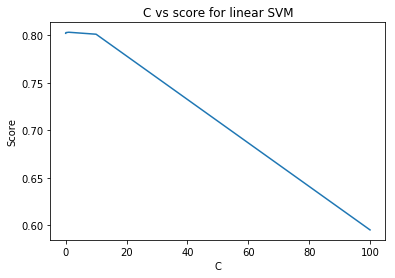

In [37]:
plt.plot(np.logspace(-3, 2, 6),results_lsvc[['mean_test_score']])
plt.title("C vs score for linear SVM")
plt.xlabel("C")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

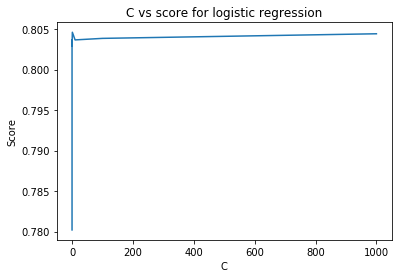

In [38]:
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000],results_lr[['mean_test_score']])
plt.title("C vs score for logistic regression")
plt.xlabel("C")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

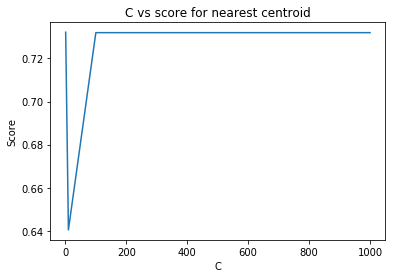

In [39]:
plt.plot([1,10,100,1000],results_nc[['mean_test_score']])
plt.title("C vs score for nearest centroid")
plt.xlabel("C")
plt.ylabel("Score")

On tuning with grid search CV, I don't find any improvement in the model. The best params are
Linear SVC C: 1.0
Logistic regression C: 1
nearest centroid : 1

In [42]:
def get_model_df(best_est,coef):
    cat_list = best_est.named_steps['columntransformer'].named_transformers_['onehotencoder'].categories_
    flat_list = [item for cat_list in cat_list for item in cat_list]
    cont = X_train.select_dtypes(exclude=['object'])
    tot_col = list(cont.columns)
    tot_col.extend(flat_list)
    df = pd.DataFrame({'cat':tot_col,'coeff':coef[0]})
    return df.reindex(df.coeff.abs().sort_values(ascending = False).index)

In [40]:
svc_coeff = gs_lsvc.best_estimator_.named_steps['linearsvc'].coef_

(1, 46)


Text(0, 0.5, 'coefficients')

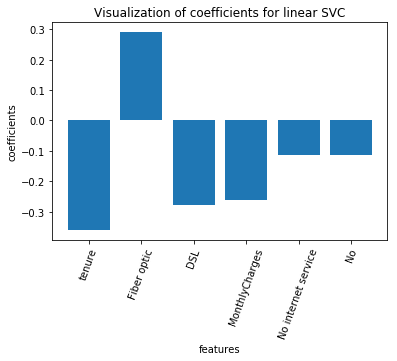

In [48]:
svc_df = get_model_df(gs_lsvc.best_estimator_,svc_coeff)
plt.xticks(rotation=70)
plt.bar(svc_df.iloc[:10,0],svc_df.iloc[:10,1])
plt.title("Visualization of coefficients for linear SVC")
plt.xlabel("features")
plt.ylabel("coefficients")

In [45]:
lr_coeff = gs_lr.best_estimator_.named_steps['logisticregression'].coef_
lr_coeff.shape

(1, 46)

Text(0, 0.5, 'coefficients')

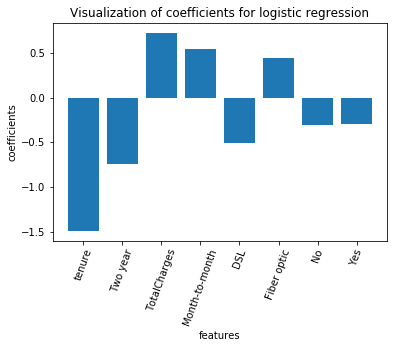

In [47]:
log_df = get_model_df(gs_lr.best_estimator_,lr_coeff)
plt.xticks(rotation=70)
plt.bar(log_df.iloc[:10,0],log_df.iloc[:10,1])
plt.title("Visualization of coefficients for logistic regression")
plt.xlabel("features")
plt.ylabel("coefficients")

The above two methods gives different importances to different features in the dataset. "Tenure","Fibre optic" and "DSL" are common in both but at different weights/importances.

The following code changes the cross validation strategy to kfold with shuffling.

In [49]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.svm import SVC

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,random_state=123)
    categorical = X_train.dtypes == object
    pipe_cont = make_pipeline(SimpleImputer(strategy='mean'),
                                         (StandardScaler()))
    scaled_lsvc = make_column_transformer((pipe_cont, ~categorical),
                                          (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    param_lsvc = {'linearsvc__C': np.logspace(-3, 2, 6)}
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    param_nc = {'nearestcentroid__shrink_threshold':[1,10,100,1000]}
    
    gs_lsvc = GridSearchCV(estimator=make_pipeline(scaled_lsvc,LinearSVC()),param_grid=param_lsvc,
                           cv=KFold(shuffle=True))
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression()),param_grid=param_lr,
                         cv=KFold(shuffle=True))
    gs_nc = GridSearchCV(estimator=make_pipeline(preprocess,NearestCentroid()),
                         param_grid=param_nc)
    gs_lsvc.fit(X_train,y_train)
    gs_lr.fit(X_train,y_train)
    gs_nc.fit(X_train,y_train)


In [50]:
print(gs_lsvc.best_params_)
print(gs_lsvc.best_score_)
print(gs_lr.best_params_)
print(gs_lr.best_score_)
print(gs_nc.best_params_)
print(gs_nc.best_score_)

{'linearsvc__C': 0.001}
0.8014009844755774
{'logisticregression__C': 0.01}
0.8034835289663006
{'nearestcentroid__shrink_threshold': 1}
0.7321090496024233


The hyperparameters do change on applying kfold with shuffling. Linear SVC's parameter was 1 previously and now it is 0.001. Similarly for logistic regression it was 1 and now it is 0.01. For nearest centroid, the shrinkage parameter did not change.

The following code changes the random state of kfold.

In [60]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.svm import SVC

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,random_state=123)
    categorical = X_train.dtypes == object
    pipe_cont = make_pipeline(SimpleImputer(strategy='mean'),
                                         (StandardScaler()))
    scaled_lsvc = make_column_transformer((pipe_cont, ~categorical),
                                          (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    param_lsvc = {'linearsvc__C': np.logspace(-3, 2, 6)}
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    param_nc = {'nearestcentroid__shrink_threshold':[1,10,100,1000]}
    
    gs_lsvc = GridSearchCV(estimator=make_pipeline(scaled_lsvc,LinearSVC()),param_grid=param_lsvc,
                           cv=KFold(shuffle=True,random_state=202))
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression()),param_grid=param_lr,
                         cv=KFold(shuffle=True,random_state=202))
    gs_nc = GridSearchCV(estimator=make_pipeline(preprocess,NearestCentroid()),
                         cv=KFold(shuffle=True,random_state=202),
                         param_grid=param_nc)
    gs_lsvc.fit(X_train,y_train)
    gs_lr.fit(X_train,y_train)
    gs_nc.fit(X_train,y_train)
    


In [61]:
print(gs_lsvc.best_params_)
print(gs_lsvc.best_score_)
print(gs_lr.best_params_)
print(gs_lr.best_score_)
print(gs_nc.best_params_)
print(gs_nc.best_score_)

{'linearsvc__C': 0.1}
0.8074592957213177
{'logisticregression__C': 1}
0.811056418023476
{'nearestcentroid__shrink_threshold': 100}
0.738356683074593


Different random states give different results. Random state of 400 gives:

LinearSVC = 0.01, Logistic regression = 0.1, Nearest centroid = 100

Random state of 202 gives:

LinearSVC = 0.1, Logistic regression = 1, Nearest centroid = 100

In [64]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.svm import SVC

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,random_state=150)
    categorical = X_train.dtypes == object
    pipe_cont = make_pipeline(SimpleImputer(strategy='mean'),
                                         (StandardScaler()))
    scaled_lsvc = make_column_transformer((pipe_cont, ~categorical),
                                          (OneHotEncoder(handle_unknown='ignore'),categorical),
                                         remainder='passthrough')
    param_lsvc = {'linearsvc__C': np.logspace(-3, 2, 6)}
    param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    param_nc = {'nearestcentroid__shrink_threshold':[1,10,100,1000]}
    
    gs_lsvc = GridSearchCV(estimator=make_pipeline(scaled_lsvc,LinearSVC()),param_grid=param_lsvc,
                           cv=KFold(shuffle=True))
    gs_lr = GridSearchCV(estimator=make_pipeline(preprocess,LogisticRegression()),param_grid=param_lr,
                         cv=KFold(shuffle=True))
    gs_nc = GridSearchCV(estimator=make_pipeline(preprocess,NearestCentroid()),
                         cv=KFold(shuffle=True),
                         param_grid=param_nc)
    gs_lsvc.fit(X_train,y_train)
    gs_lr.fit(X_train,y_train)
    gs_nc.fit(X_train,y_train)


In [65]:
print(gs_lsvc.best_params_)
print(gs_lsvc.best_score_)
print(gs_lr.best_params_)
print(gs_lr.best_score_)
print(gs_nc.best_params_)
print(gs_nc.best_score_)

{'linearsvc__C': 1.0}
0.7970465732677017
{'logisticregression__C': 10}
0.7962892843619841
{'nearestcentroid__shrink_threshold': 100}
0.7298371828852708


Changing random state of the train test split also changes the hyperparameters. A state of 200 gives:

LinearSVC = 0.001, Logistic regression = 10, Nearest centroid = 100

A state of 150 gives:

LinearSVC = 1, Logistic regression = 10, Nearest centroid = 100

It is to be noted that the random state change brings about a change only in the hyperparameters, however the performance remains the same for the models.